In [69]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# !pip install torchsummary
from torchsummary import summary

In [3]:
torch.manual_seed(1)
batch_size = 128
lr = 0.01
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [4]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_loss_arr.append(test_loss)
    accuracy_arr.append(100. * correct / len(test_loader.dataset))
    print('\nEpoch: {}, Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [183]:
# Conditions to meet:
# 99.4% validation accuracy
# Less than 20k Parameters
# Less than 20 Epochs

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.nn = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
                nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1),
                nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(8, 16, 3, padding=1),
                nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
                nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, 3),
                nn.ReLU(),
            nn.Conv2d(32, 32, 3),
                nn.ReLU(),
            nn.Conv2d(32, 10, 1),
            nn.AvgPool2d(3)
        )

    def forward(self, x):
        x = self.nn(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [184]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             584
              ReLU-4            [-1, 8, 28, 28]               0
       BatchNorm2d-5            [-1, 8, 28, 28]              16
         MaxPool2d-6            [-1, 8, 14, 14]               0
            Conv2d-7           [-1, 16, 14, 14]           1,168
              ReLU-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           2,320
             ReLU-10           [-1, 16, 14, 14]               0
      BatchNorm2d-11           [-1, 16, 14, 14]              32
        MaxPool2d-12             [-1, 16, 7, 7]               0
           Conv2d-13             [-1, 32, 5, 5]           4,640
             ReLU-14             [-1, 3

C:\Users\focusedmonk\AppData\Local\Temp\ipykernel_30492\3122421151.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [185]:
### model = Net().to(device)
test_loss_arr = []
accuracy_arr = []
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs = 20

for epoch in range(1, epochs+1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader, epoch)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]C:\Users\focusedmonk\AppData\Local\Temp\ipykernel_30492\3122421151.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=0.14194756746292114 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:14<00:00, 33.27it/s]



Epoch: 1, Test set: Average loss: 0.0650, Accuracy: 9798/10000 (97.980%)



loss=0.059003546833992004 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:13<00:00, 34.96it/s]



Epoch: 2, Test set: Average loss: 0.0554, Accuracy: 9819/10000 (98.190%)



loss=0.03987615928053856 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:13<00:00, 34.25it/s]



Epoch: 3, Test set: Average loss: 0.0406, Accuracy: 9874/10000 (98.740%)



loss=0.004294338636100292 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:13<00:00, 33.74it/s]



Epoch: 4, Test set: Average loss: 0.0375, Accuracy: 9880/10000 (98.800%)



loss=0.021271876990795135 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:13<00:00, 34.40it/s]



Epoch: 5, Test set: Average loss: 0.0327, Accuracy: 9895/10000 (98.950%)



loss=0.015065344981849194 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:14<00:00, 33.50it/s]



Epoch: 6, Test set: Average loss: 0.0355, Accuracy: 9888/10000 (98.880%)



loss=0.0030502788722515106 batch_id=468: 100%|███████████████████████████████████████| 469/469 [00:13<00:00, 36.01it/s]



Epoch: 7, Test set: Average loss: 0.0467, Accuracy: 9837/10000 (98.370%)



loss=0.007221200969070196 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:13<00:00, 34.06it/s]



Epoch: 8, Test set: Average loss: 0.0348, Accuracy: 9887/10000 (98.870%)



loss=0.008761454373598099 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:13<00:00, 34.46it/s]



Epoch: 9, Test set: Average loss: 0.0362, Accuracy: 9886/10000 (98.860%)



loss=0.03797650709748268 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:13<00:00, 34.55it/s]



Epoch: 10, Test set: Average loss: 0.0319, Accuracy: 9907/10000 (99.070%)



loss=0.023922361433506012 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:13<00:00, 34.30it/s]



Epoch: 11, Test set: Average loss: 0.0271, Accuracy: 9906/10000 (99.060%)



loss=0.018082693219184875 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:13<00:00, 34.88it/s]



Epoch: 12, Test set: Average loss: 0.0264, Accuracy: 9915/10000 (99.150%)



loss=0.010037104599177837 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:13<00:00, 35.12it/s]



Epoch: 13, Test set: Average loss: 0.0276, Accuracy: 9916/10000 (99.160%)



loss=0.00024924008175730705 batch_id=468: 100%|██████████████████████████████████████| 469/469 [00:13<00:00, 34.72it/s]



Epoch: 14, Test set: Average loss: 0.0226, Accuracy: 9926/10000 (99.260%)



loss=0.032180678099393845 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:13<00:00, 34.46it/s]



Epoch: 15, Test set: Average loss: 0.0401, Accuracy: 9872/10000 (98.720%)



loss=0.0017514177598059177 batch_id=468: 100%|███████████████████████████████████████| 469/469 [00:14<00:00, 32.61it/s]



Epoch: 16, Test set: Average loss: 0.0276, Accuracy: 9920/10000 (99.200%)



loss=0.00724516436457634 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:14<00:00, 33.04it/s]



Epoch: 17, Test set: Average loss: 0.0306, Accuracy: 9915/10000 (99.150%)



loss=0.003933089319616556 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:13<00:00, 34.04it/s]



Epoch: 18, Test set: Average loss: 0.0308, Accuracy: 9909/10000 (99.090%)



loss=0.005942223593592644 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:13<00:00, 34.75it/s]



Epoch: 19, Test set: Average loss: 0.0280, Accuracy: 9923/10000 (99.230%)



loss=0.006367290858179331 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:13<00:00, 34.76it/s]



Epoch: 20, Test set: Average loss: 0.0348, Accuracy: 9901/10000 (99.010%)



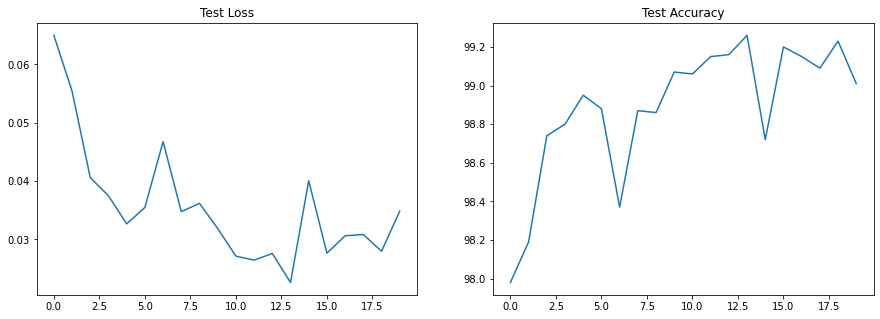

In [186]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(test_loss_arr)
plt.title('Test Loss')
plt.subplot(1, 2, 2)
plt.plot(accuracy_arr)
plt.title('Test Accuracy')
plt.show()